<a href="https://colab.research.google.com/github/kimdahyeon977/plant_pathology/blob/main/metriclearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Metric Learning
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/엘리스_AI프로젝트 /

/content/drive/Shareddrives/엘리스_AI프로젝트 


In [ ]:
!pip install pytorch-metric-learning
!pip install -q faiss-gpu
#!git clone https://github.com/akamaster/pytorch_resnet_cifar10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 4.9 MB/s 
     |████████████████████████████████| 85.5 MB 112 kB/s 


## Import the packages

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from pytorch_resnet_cifar10 import resnet
from torchvision import datasets, transforms

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

## Create helper functions

In [ ]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")


mean = [0.4244042, 0.56010085, 0.35498324]
std = [0.18389933, 0.19130534, 0.18172114]

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Create the dataset and load the trained model

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('data_labels.csv')
df=df[df.duplicated(subset=['filename'])]
un=['Potato leaf early blight',
'Tomato leaf yellow virus',
'Tomato leaf bacterial spot',
'Tomato Septoria leaf spot',
'Bell_pepper leaf spot',
'Tomato Early blight leaf',
'Corn leaf blight',
'Tomato mold leaf',
'Tomato leaf late blight',
'Apple Scab Leaf',
'Potato leaf late blight',
'Squash Powdery mildew leaf',
'Tomato leaf mosaic virus',
'Apple rust leaf',
'grape leaf black rot',
'Corn rust leaf',
'Corn Gray leaf spot',
'Tomato two spotted spider mites leaf']
df['label']=df['label'].map(lambda x : x.replace(x,'unhealthy') if x in un else 'healthy')
base_path='/content/drive/Shareddrives/엘리스_AI프로젝트 /PlantDoc-Object-Detection-Dataset/'

In [ ]:
df.to_csv('/content/drive/Shareddrives/엘리스_AI프로젝트 /PlantDoc-Object-Detection-Dataset/labels_data.csv')

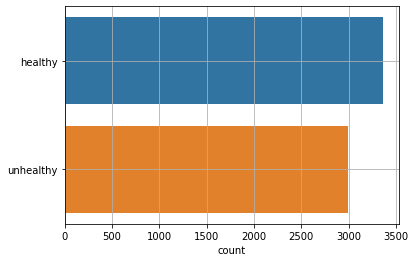

In [ ]:
import itertools
import seaborn as sns

labels_all = list(df['label'])
ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

In [ ]:
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data_labels.csv'),
        path_img_dir: str = os.path.join(base_path, '/TRAIN/'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(self.data['label'])
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        self.img_names = list(self.data['filename'])
        self.labels = list(self.data['label'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        try:
          for lb in labels.split(" "):
              one_hot[self.labels_lut[lb]] = 1
          return tuple(one_hot)
        except Exception:
          pass

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        label = self.labels[idx]
        try:
          img = plt.imread(img_path)
          # augmentation
          if self.transforms:
              img = self.transforms(Image.fromarray(img))
          label = self.to_one_hot(label)
          label=np.argmax(label).reshape(-1,1)
          return img, torch.tensor(label[0][0])
        except Exception:
          pass
    def __len__(self) -> int:
        return len(self.data)

# ==============================
# ==============================

dataset = PlantPathologyDataset()

len(dataset)

8921

In [ ]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = os.path.join(base_path, 'data_labels.csv'),
        path_img_dir: str = os.path.join(base_path, '/TRAIN/'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs in dm.test_dataloader():
    # print(len(imgs))
    # print(lbs[0:3])
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        #print(np.amin(img[i]))
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

training dataset: 8921
test dataset: 8921
29


TypeError: ignored

<Figure size 216x504 with 0 Axes>

In [ ]:
for i in range(9):
    img, lb = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)
dataset = dm.train_dataset
labels_to_indices = c_f.get_labels_to_indices(df['label'])
model = torch.nn.DataParallel(resnet.resnet20())
checkpoint = torch.load("/content/pytorch_resnet_cifar10/pretrained_models/resnet20-12fca82f.th")
model.load_state_dict(checkpoint["state_dict"])
model.module.linear = c_f.Identity()
model.to(torch.device("cuda"))
print("done model loading")

done model loading


In [ ]:
labels_to_indices.keys()

dict_keys(['unhealthy', 'healthy'])

## Create the InferenceModel wrapper

In [ ]:
match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(model, match_finder=match_finder)

# cars and frogs
classA, classB = labels_to_indices['unhealthy'], labels_to_indices['healthy']

## Get nearest neighbors of a query

In [ ]:
# create faiss index
try:
  inference_model.train_knn(dm.train_dataset)
except Exception:pass

In [ ]:
inference_model.save_knn_func("secondmodel.index")

RuntimeError: ignored

In [ ]:
# get 10 nearest neighbors for a car image
for img_type in [classA, classB]:
    #img = dataset[img_type[0]][0].unsqueeze(0)
    img=dm.train_dataset[1][0].unsqueeze(0)
    print("query image")
    imshow(torchvision.utils.make_grid(img))
    distances, indices = inference_model.get_nearest_neighbors(img, k=10)
    print(distances)
    nearest_imgs = [dataset[i][0] for i in indices.cpu()[0]]
    print("nearest images")
    imshow(torchvision.utils.make_grid(nearest_imgs))

TypeError: ignored

## Compare two images of the same class

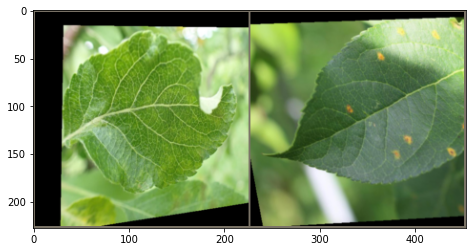

True
Same class


In [ ]:
# compare two images of the same class
(x, _), (y, _) = dataset[classA[0]], dataset[classA[1]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare two images of different classes

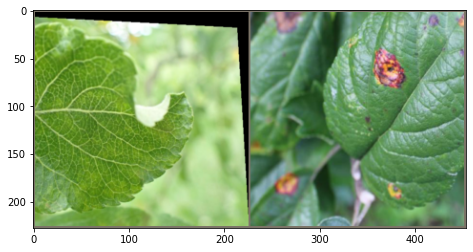

Same class


In [ ]:
# compare two images of a different class
(x, _), (y, _) = dataset[classA[0]], dataset[classB[0]]
imshow(torchvision.utils.make_grid(torch.stack([x, y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Compare multiple pairs of images

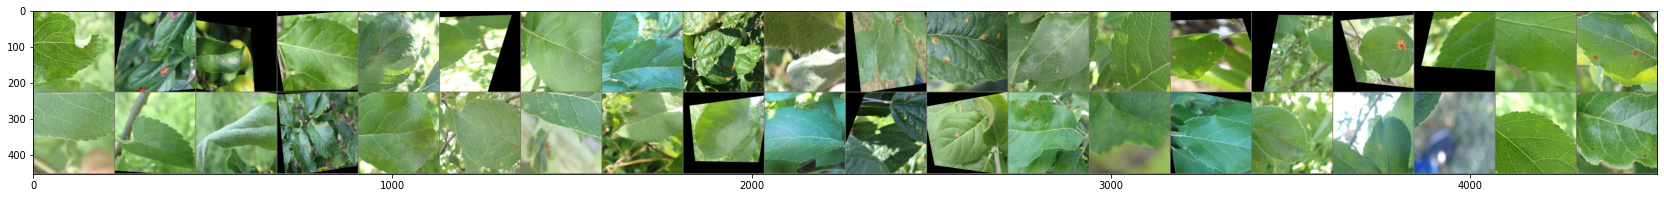

Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
Same class
accuracy = 1.0


In [ ]:
# compare multiple pairs of images
x = torch.zeros(20, 3, 224, 224)
y = torch.zeros(20, 3, 224, 224)
for i in range(0, 20, 2):
    x[i] = dataset[classA[i]][0]
    x[i + 1] = dataset[classB[i]][0]
    y[i] = dataset[classA[i + 20]][0]
    y[i + 1] = dataset[classB[i + 20]][0]
imshow(torchvision.utils.make_grid(torch.cat((x, y), dim=0), nrow=20), figsize=(30, 3))
decision = inference_model.is_match(x, y)
for d in decision:
    print_decision(d)
print("accuracy = {}".format(np.sum(decision) / len(x)))

## Compare all pairs within a batch

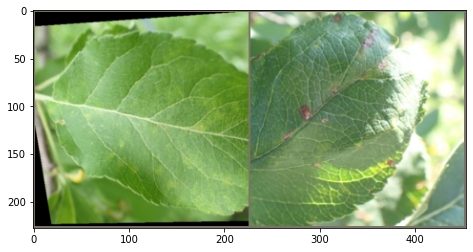

Same class


In [ ]:
# compare all pairs within a batch
match_matrix = inference_model.get_matches(x)
assert match_matrix[0, 0]  # the 0th image should match with itself
imshow(torchvision.utils.make_grid(torch.stack((x[3], x[4]), dim=0)))
print_decision(match_matrix[3, 4])  # does the 3rd image match the 4th image?

## Compare all pairs between queries and references

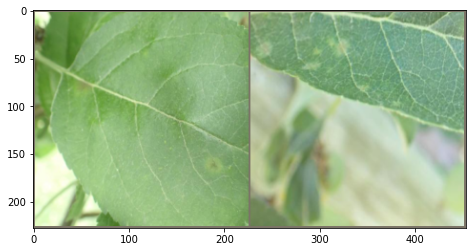

Same class


In [ ]:
# compare all pairs between queries and references
match_matrix = inference_model.get_matches(x, y)
imshow(torchvision.utils.make_grid(torch.stack((x[6], y[6]), dim=0)))
print_decision(match_matrix[6, 6])  # does the 6th query match the 6th reference?

# Get results in tuple form